In [1]:
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Load the dataset
#Atlanta_Distance = pd.read_pickle(r'~/Documents/NYCDSA/Capstone/Pickle Files/Atlanta_Nearest_POI.pkl')
Atlanta_Distance = pd.read_csv('~/Documents/NYCDSA/Capstone/Nearest_Distances_Atlanta/Atlanta_Nearest_Distances.csv')
Atlanta_Distance['TotalBath'] = Atlanta_Distance['number_of_full_baths'] + (Atlanta_Distance['number_of_half_baths']*0.5)
Atlanta_Distance = Atlanta_Distance.drop(columns=['ID', 'year_built', 'source_name',
                                                  'listing_date', 'mls_id', 'census_zcta5_geoid',
                                                  'census_cbsa_geoid', 'latitude', 'longitude', 'lot_size_in_acres', 'number_of_full_baths', 'number_of_half_baths'])
Atlanta_Distance

,street_address,city,state,current_listing_price,number_of_bedrooms,living_area_square_feet,lot_size_in_square_feet,has_pool,has_garage,number_of_garage_spaces,...,Distance_SC,Convenience_POI,Distance_C,Supermarket_POI,Distance_SM,Variety_store_POI,Distance_VS,Wholesale_POI,Distance_WS,TotalBath
0,0 ivy MNR DR NW 0,Marietta,GA,2865,4,3259.0,14810.400390,False,True,NaN,...,2539.28,Sunoco,2715.74,Kroger,1654.08,Bargain Hunt,6405.99,Atlanta Wholesale,10917.45,2.5
1,1 10 buena VIS CIR SE,Cartersville,GA,2200,3,1993.0,NaN,False,False,NaN,...,492.63,Mack's Express,1407.26,Publix,3065.55,Dollar Tree,405.11,LI Global Liquidation,32739.68,2.0
2,1 1088 coldwater DR,Griffin,GA,2000,3,1910.0,NaN,False,True,NaN,...,25413.80,Unnamed POI,3213.19,Kroger,3780.13,Dollar General,4738.04,Costco,29267.11,2.0
3,1 1130 willivee DR,Decatur,GA,1995,3,1134.0,NaN,False,False,NaN,...,7857.71,Food Mart,2385.60,Publix,2320.59,Dollar Tree,4356.55,Sam's Club,9020.53,1.0
4,1 1307 idlewood CT,Mcdonough,GA,2800,4,2532.0,NaN,False,True,NaN,...,11676.91,Crossings at McDonough,14263.22,Kroger,5625.35,Dollar Tree,6721.22,Costco,14750.79,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21025,procurement only - 66 4th ST,Newnan,GA,1600,3,1367.0,NaN,False,True,NaN,...,19852.16,Newnan Lakes Chevron,4983.93,Little Giant Supermaket,2097.35,Family Dollar,6409.21,Two Valleys Distribution,47285.12,2.0
21026,r2188 executive DR,Duluth,GA,2199,3,1696.0,871.199981,False,False,NaN,...,4864.86,Unnamed POI,1477.04,Mega Mart,888.22,Dollar Tree,6142.54,Sam's Club,2009.36,2.5
21027,r3339 woodward down,Buford,GA,2380,3,1944.0,4356.000065,False,False,NaN,...,1359.41,Walgreens,3952.51,ALDI,1158.08,Five Below,714.63,Sam's Club,1507.23,3.5
21028,singleunit 216 greensprings DR,Palmetto,GA,1900,4,1204.0,NaN,False,False,NaN,...,10787.35,Flash Foods,1242.13,Publix,8779.81,Family Dollar,1402.52,Costco,40632.51,2.0


In [2]:
# Exclude 'current_listing_price' from features
numeric_features = Atlanta_Distance.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
#categorical_features = list(Atlanta_Distance.columns[Atlanta_Distance.dtypes == 'object'])

In [3]:
# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for nominal categorical features: Fill missing values with 'None' then apply one-hot encoding
#categorical_transformer = Pipeline(steps=[
    #('impute_none', SimpleImputer(strategy='constant', fill_value='None')),  # Using SimpleImputer
    #('onehot', OneHotEncoder(handle_unknown='ignore'))
#])

# Combined preprocessor for numeric and nominal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('nominal', categorical_transformer, categorical_features)
])

transformed_data = preprocessor.fit_transform(Atlanta_Distance)

In [4]:
# Generate column names for the one-hot encoded features
#onehot_features = preprocessor.named_transformers_['nominal'].named_steps['onehot'].get_feature_names_out()
# Combine all feature names
all_feature_names = list(numeric_features)
all_feature_names

['number_of_bedrooms',
 'living_area_square_feet',
 'lot_size_in_square_feet',
 'number_of_garage_spaces',
 'number_of_stories',
 'Distance_SC',
 'Distance_C',
 'Distance_SM',
 'Distance_VS',
 'Distance_WS',
 'TotalBath']

In [5]:
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)
transformed_df

,number_of_bedrooms,living_area_square_feet,lot_size_in_square_feet,number_of_garage_spaces,number_of_stories,Distance_SC,Distance_C,Distance_SM,Distance_VS,Distance_WS,TotalBath
0,0.641597,1.314458,-0.032969,-7.852818e-16,4.979361e-03,-0.853173,-0.558145,-0.543492,0.542177,-0.636596,0.050686
1,-0.459495,0.111649,0.000000,-7.852818e-16,-3.328122e-17,-1.210464,-0.973201,-0.086966,-1.156373,1.494897,-0.167469
2,-0.459495,0.032791,0.000000,-7.852818e-16,-3.328122e-17,3.140114,-0.400352,0.144158,0.070063,1.155713,-0.167469
3,-0.459495,-0.704476,0.000000,-7.852818e-16,-3.328122e-17,0.075285,-0.662867,-0.327916,-0.037918,-0.821878,-0.603778
4,0.641597,0.623745,0.000000,-7.852818e-16,-3.328122e-17,0.742016,3.104770,0.740976,0.631403,-0.262173,-0.167469
...,...,...,...,...,...,...,...,...,...,...,...
21025,-0.459495,-0.483106,0.000000,-7.852818e-16,-3.328122e-17,2.169198,0.161335,-0.400121,0.543088,2.915627,-0.167469
21026,-0.459495,-0.170527,-0.033365,-7.852818e-16,-3.328122e-17,-0.447188,-0.951067,-0.791202,0.467607,-1.506697,0.050686
21027,-0.459495,0.065094,-0.033266,-7.852818e-16,-3.328122e-17,-1.059147,-0.165836,-0.703919,-1.068764,-1.555742,0.486995
21028,0.641597,-0.637970,0.000000,-7.852818e-16,-3.328122e-17,0.586722,-1.025581,1.761256,-0.874056,2.265832,-0.167469


In [6]:
from sklearn.ensemble import RandomForestRegressor
# Assuming RandomForest is part of your models dictionary
random_forest_model = RandomForestRegressor(random_state = 42)
# Define the full model pipeline including the preprocessor and RandomForestRegressor
random_forest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', random_forest_model)
])
# Fit the model pipeline
random_forest_pipeline.fit(Atlanta_Distance.drop(columns='current_listing_price'), Atlanta_Distance['current_listing_price'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['number_of_bedrooms', 'living_area_square_feet',
       'lot_size_in_square_feet', 'number_of_garage_spaces',
       'number_of_stories', 'Distance_SC', 'Distance_C', 'Distance_SM',
       'Distance_VS', 'Distance_WS', 'TotalBath'],
      dtype='object'))])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [7]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(random_forest_pipeline, Atlanta_Distance.drop(columns='current_listing_price'), Atlanta_Distance['current_listing_price'], scoring = 'r2', cv=kf, n_jobs = -1)
print('Avg Score:',np.mean(scores))

Avg Score: 0.5879749301544683


In [8]:
feature_importances = random_forest_pipeline.named_steps['regressor'].feature_importances_

In [9]:
# Function to extract feature names from ColumnTransformer
def get_feature_names(column_transformer):
    """Generate feature names from a ColumnTransformer"""
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:  # the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1], Pipeline):
            # if pipeline, get the last transformer
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names_out(raw_col_name)
        except AttributeError:  # if no 'get_feature_names_out' function, use raw column name
            names = raw_col_name
        if isinstance(names, np.ndarray):
            col_name.extend(names.tolist())
        else:
            col_name.extend(names)
    return col_name
# Apply function to get feature names
feature_names = get_feature_names(preprocessor)
# Create a DataFrame to view feature names and their corresponding importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Display the sorted DataFrame
importance_df

,Feature,Importance
1,living_area_square_feet,0.309850
10,TotalBath,0.126206
9,Distance_WS,0.111512
6,Distance_C,0.098746
7,Distance_SM,0.095056
5,Distance_SC,0.084246
8,Distance_VS,0.063105
2,lot_size_in_square_feet,0.047421
0,number_of_bedrooms,0.029535
4,number_of_stories,0.022919


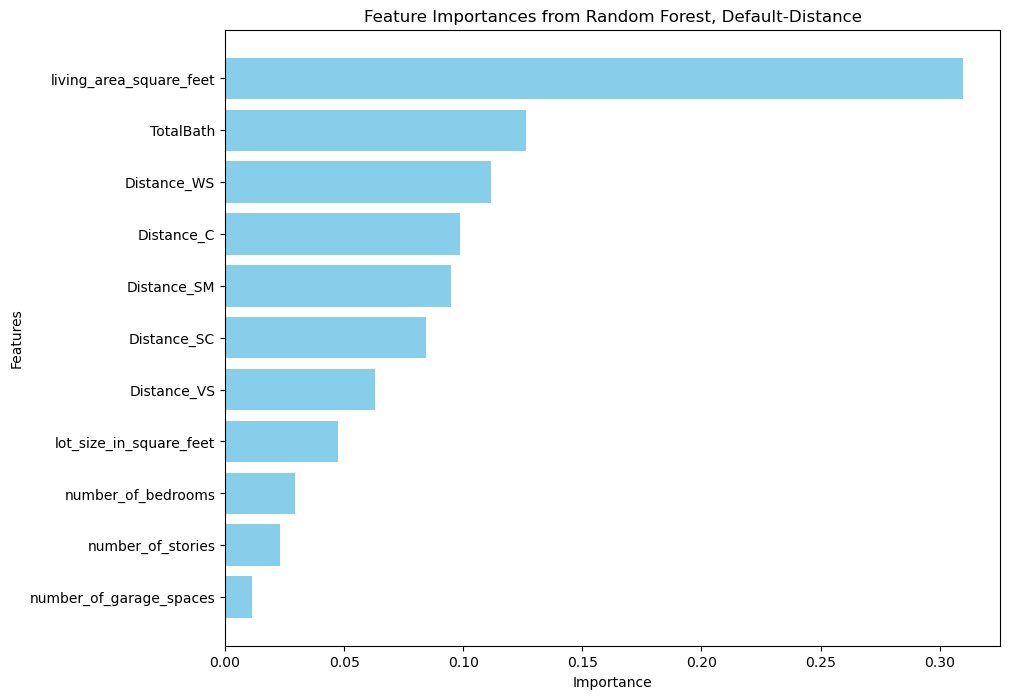

In [10]:
import matplotlib.pyplot as plt
# Sort the DataFrame by importance (if not already sorted)
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Select the top N features for a cleaner graph, you can adjust N based on your needs
top_n = 25
top_features = importance_df.head(top_n)
# Create a bar plot for the feature importances
plt.figure(figsize=(10, 8))  # Set the figure size (width, height in inches)
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances from Random Forest, Default-Distance')
plt.gca().invert_yaxis()  # Invert the Y-axis to show the highest values at the top
plt.show()

In [11]:
param_grid = {'regressor__n_estimators': [140, 150, 160], 
                                 'regressor__max_depth': [None],
                                 'regressor__min_samples_leaf': [1], 
                                 'regressor__max_features': [None],
                                 'regressor__min_samples_split': [2]  # Minimum number of data points allowed in a leaf node
}
from sklearn.model_selection import GridSearchCV
# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=random_forest_pipeline, param_grid=param_grid, cv=kf, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(Atlanta_Distance.drop(columns='current_listing_price'), Atlanta_Distance['current_listing_price'])

Fitting 10 folds for each of 3 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('impute_mean',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['number_of_bedrooms', 'living_area_square_feet',
       'lot_size_in_square_feet', 'number_of_garage_spaces',
       'number_of_stories', '...', 'Distance_C', 'Distance_SM',
       'Distance_VS', 'Distance_WS', 'TotalBath'],
      dtype='object'))])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None],
                         'regressor__max_features': [None],
                         'regressor__min_samples_leaf': [1],
                         'regressor__min_samples_split': [2],
                         'regressor__n_estimators': [140, 150, 160]},
             verbose=2)

In [12]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)
# Get the best estimator
best_rf = grid_search.best_estimator_
print("Best estimator:", best_rf)
# Optionally, review the best score (which is the mean cross-validated score of the best_estimator)
best_score = grid_search.best_score_
print("Best score (R2):", best_score)

Best parameters: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 160}
Best estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['number_of_bedrooms', 'living_area_square_feet',
       'lot_size_in_square_feet', 'number_of_garage_spaces',
       'number_of_stories', 'Distance_SC', 'Distance_C', 'Distance_SM',
       'Distance_VS', 'Distance_WS', 'TotalBath'],
      dtype='object'))])),
                ('regressor',
                 RandomForestRegr

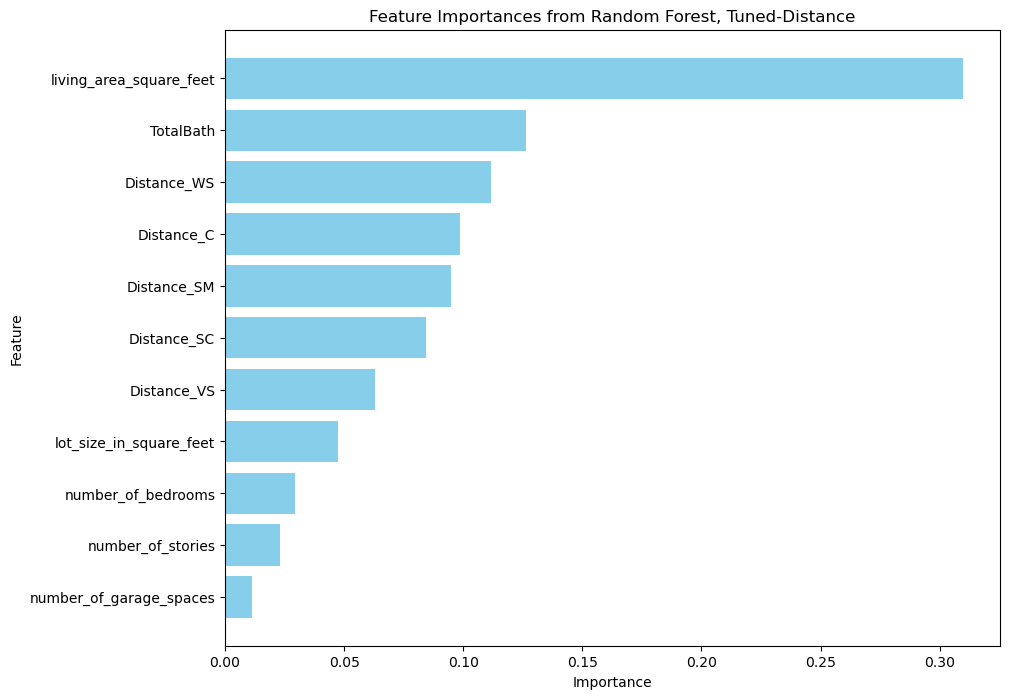

In [13]:
import matplotlib.pyplot as plt
# Plotting feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'][:25], importance_df['Importance'][:25], color='skyblue')  # Top 20 features
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest, Tuned-Distance')
plt.gca().invert_yaxis()
plt.show()